# Questions

# Question 1
Develop a model to predict the probability of winning an auction based on our bid and the item feature x. If you can think of a way, the model should ideally also be able to predict the confidence of predictions.

In [7]:
import os

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

from src import settings

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (9, 3)

## Build a baseline model based on X and the bidding price

In [25]:
df = pd.read_csv(os.path.join(settings.PROJECT_ROOT, settings.AUCTION_SUMMARY_FILE))

In [26]:
df = df.assign(winning_bid=lambda x: (x.bid >= x.auctions).astype(int))
df.winning_bid.value_counts()

winning_bid
0    457
1     48
Name: count, dtype: int64

In [27]:
df.head()

,x,bid,auctions,wins,winning_bid
0,0.585202,2.719391,7,7,0
1,4.567498,2.688336,2,2,1
2,1.481628,0.200173,4,0,0
3,0.828790,0.187734,4,0,0
4,1.988679,5.792509,7,7,0


In [28]:
df = df.assign(train_test=lambda x: np.random.choice(["train", "test"], size=x.shape[0], p=[0.8, 0.2]))

In [29]:
df.train_test.value_counts()

train_test
train    413
test      92
Name: count, dtype: int64

In [52]:
X_train = df.query("train_test == 'train'").copy()
X_test = df.query("train_test == 'test'").copy()

In [53]:
model = smf.logit("winning_bid ~ x + bid", data=X_train)

In [54]:
res = model.fit()

Optimization terminated successfully.
         Current function value: 0.226428
         Iterations 8


In [55]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            winning_bid   No. Observations:                  413
Model:                          Logit   Df Residuals:                      410
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Apr 2024   Pseudo R-squ.:                  0.2758
Time:                        10:02:14   Log-Likelihood:                -93.515
converged:                       True   LL-Null:                       -129.13
Covariance Type:            nonrobust   LLR p-value:                 3.397e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8269      0.569     -8.489      0.000      -5.941      -3.713
x              0.1952      0.117      1.671      0.095      -0.034       0.424
bid            0.7937      0.108      7.320      0.000       0.581       1.006
==============================================================================
"""

## Test the model

In [57]:
X_train = X_train.assign(predictions=res.predict(exog=X_train))

In [58]:
X_test = X_test.assign(predictions=res.predict(exog=X_test))

<Axes: xlabel='bid', ylabel='predictions'>

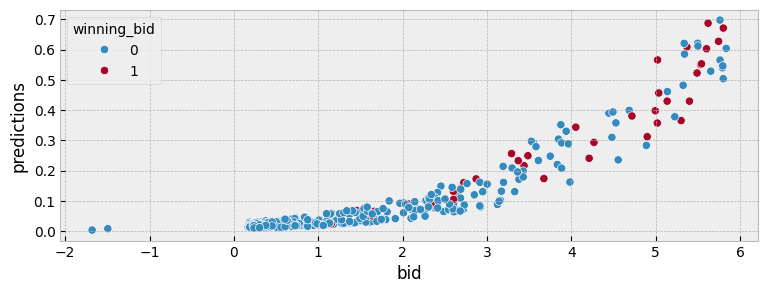

In [59]:
sns.scatterplot(X_train, x="bid", y="predictions", hue="winning_bid")

<Axes: xlabel='bid', ylabel='predictions'>

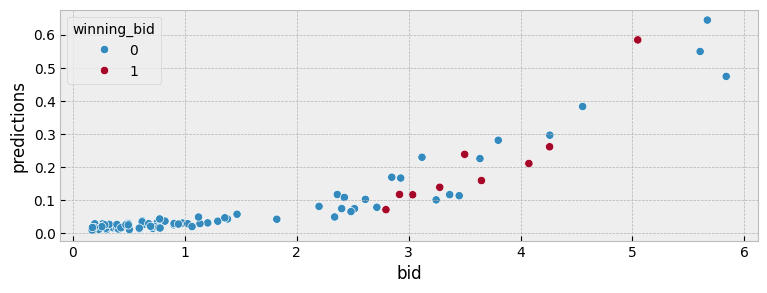

In [60]:
sns.scatterplot(X_test, x="bid", y="predictions", hue="winning_bid")

# Question 2
Derive the probability density function for the winning bid for x=3. What is the probability that the winning bid lies between 1 and 2?

## Derive the probability density function for the winning bid for x=3

In [103]:
X_test_cond = pd.concat([
    pd.DataFrame({"bid": np.arange(0, 11, 0.1), "x": x})
    for x in range(1, 9, 2)
], ignore_index=True)
X_test_cond["cdf"] = res.predict(X_test_cond)

In [113]:
X_test_cond["pdf"] = model.pdf(np.dot(
    X_test_cond.assign(intercept=1)[["intercept", "x", "bid"]].values,
    res.params.values
))

* We derive the probability of winning for different values of x, containing x=3.

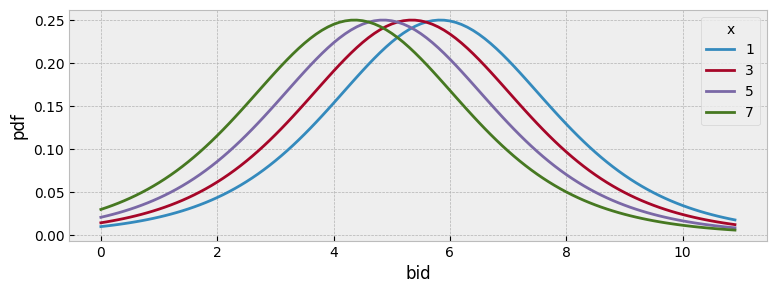

In [114]:
sns.lineplot(X_test_cond.astype({"x": "category"}), x="bid", y="pdf", hue="x");

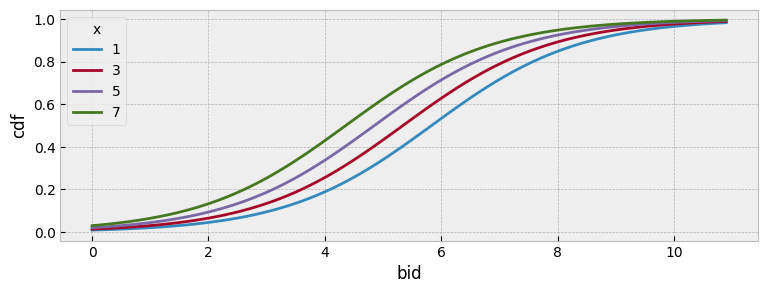

In [115]:
sns.lineplot(X_test_cond.astype({"x": "category"}), x="bid", y="cdf", hue="x");

> the probability of winning the bid increases as x increase. We also analysed in the EDA that the value of the auction was a decreasing function of x. If other biders have the information, they are more willing to pay higher price for low value of x making the **auctions more difficult to win** for **lower x** values.

## What is the probability that the winning bid lies between 1 and 2?

# Question 3
Let’s assume that we participate again on an identical set of auctions with the same bids as in the provided dataset. Based on your model, what is the probability of observing costs larger than in the provided dataset?